In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# read in values
sigA = pd.read_csv('sigA.csv', header=None, names=["time", "sig"])
sigB = pd.read_csv('sigB.csv', header=None, names=["time", "sig"])
sigC = pd.read_csv('sigC.csv', header=None, names=["time", "sig"])
sigD = pd.read_csv('sigD.csv', header=None, names=["time", "sig"])

sigs = [sigA, sigB, sigC, sigD]
names = ["A", "B", "C", "D"]

Text(0.5, 1.0, 'Signal D vs Time')

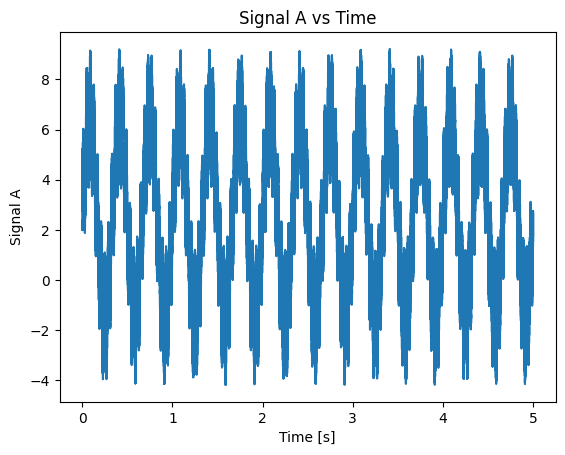

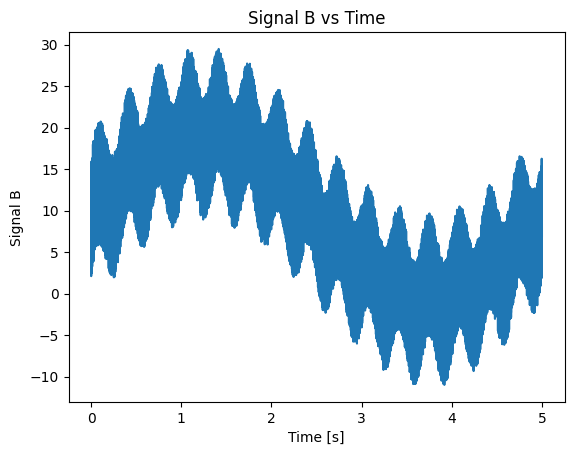

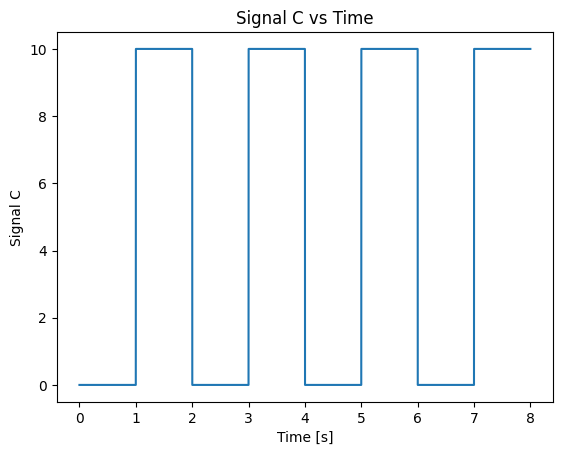

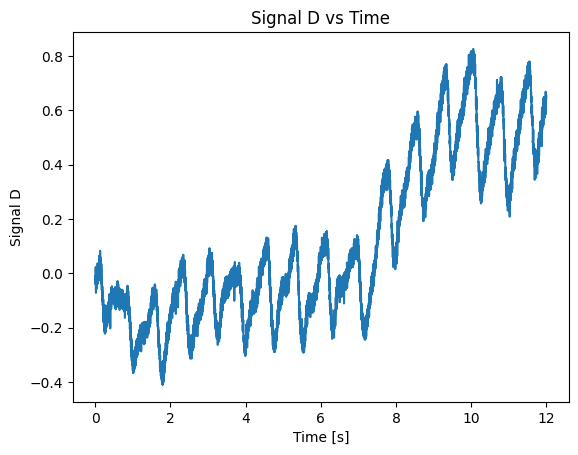

In [3]:
#plot
plt.figure()
plt.plot(sigA['time'], sigA['sig'])
plt.xlabel('Time [s]')
plt.ylabel('Signal A')
plt.title('Signal A vs Time')

plt.figure()
plt.plot(sigB['time'], sigB['sig'])
plt.xlabel('Time [s]')
plt.ylabel('Signal B')
plt.title('Signal B vs Time')

plt.figure()
plt.plot(sigC['time'], sigC['sig'])
plt.xlabel('Time [s]')
plt.ylabel('Signal C')
plt.title('Signal C vs Time')

plt.figure()
plt.plot(sigD['time'], sigD['sig'])
plt.xlabel('Time [s]')
plt.ylabel('Signal D')
plt.title('Signal D vs Time')

In [4]:
# get sample rate
fss = []
for sig in sigs:
    n = sig['time'].size - 1 
    fs = n / (sig['time'].iloc[-1] - sig['time'].iloc[0]) 
    fss.append(fs)

fss

[10000.0, 3300.0, 2500.0, 400.0]

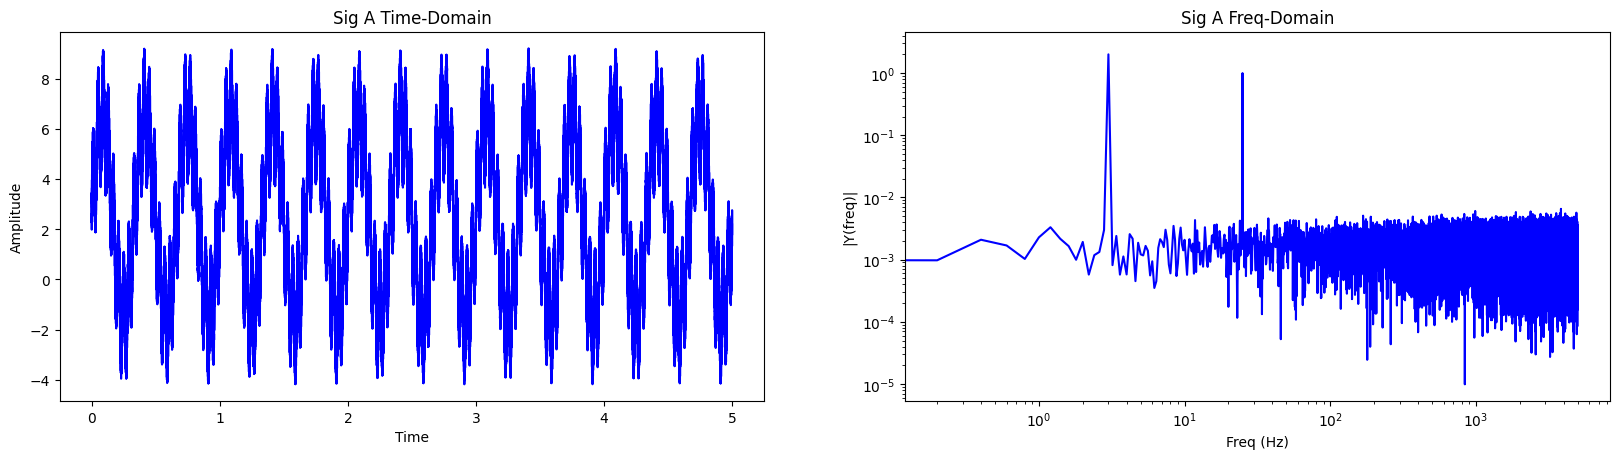

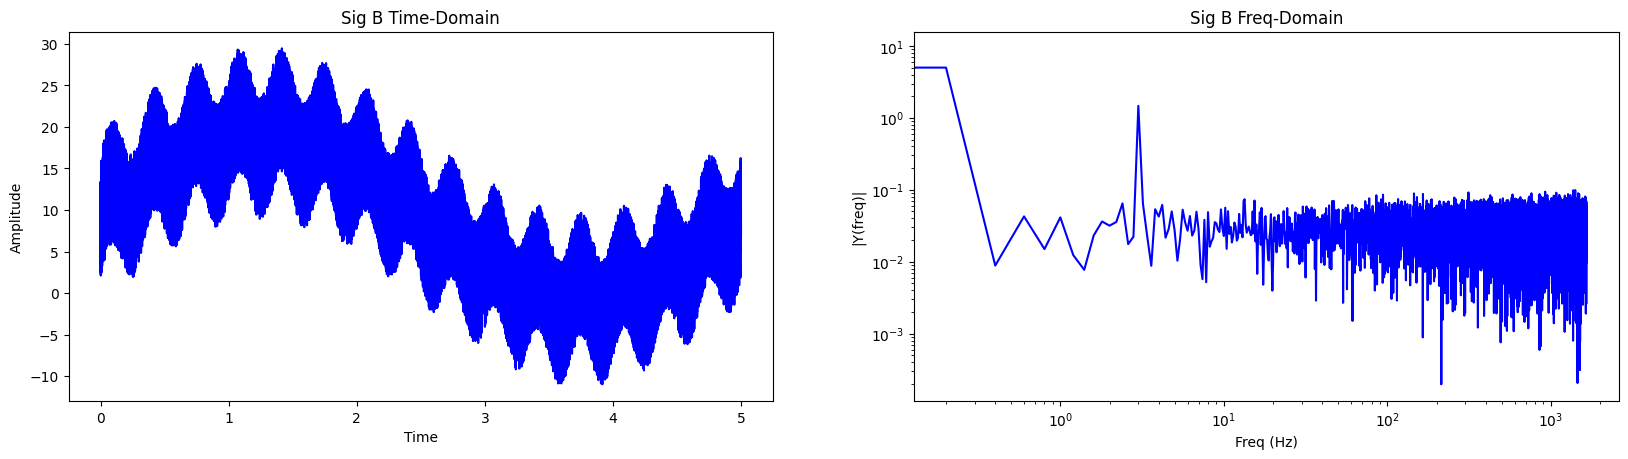

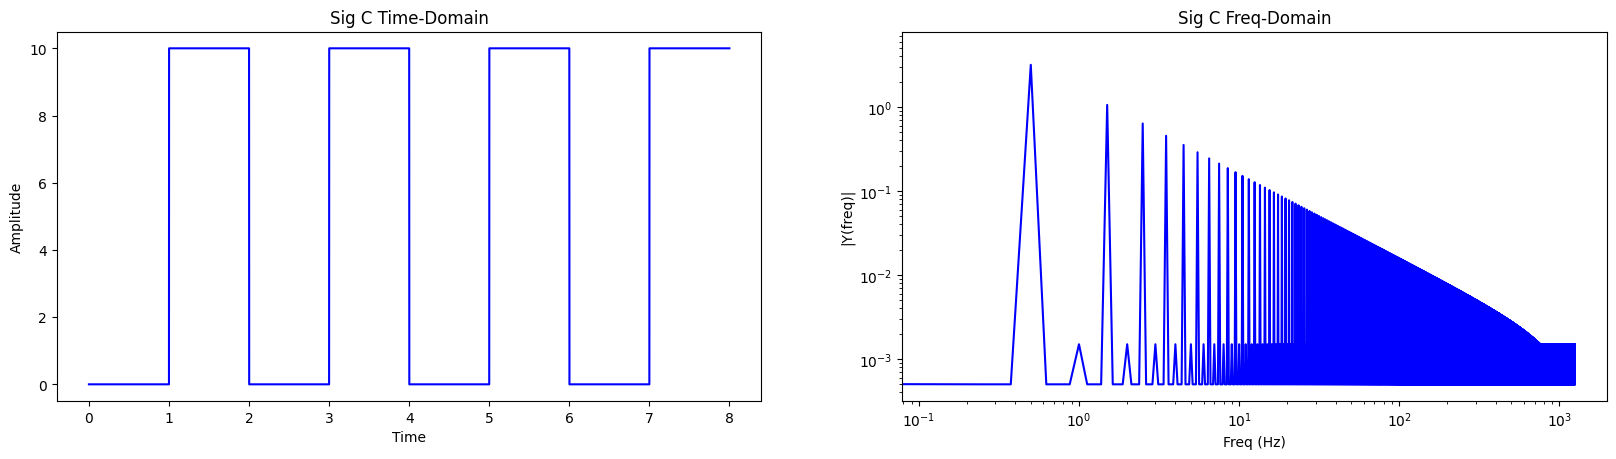

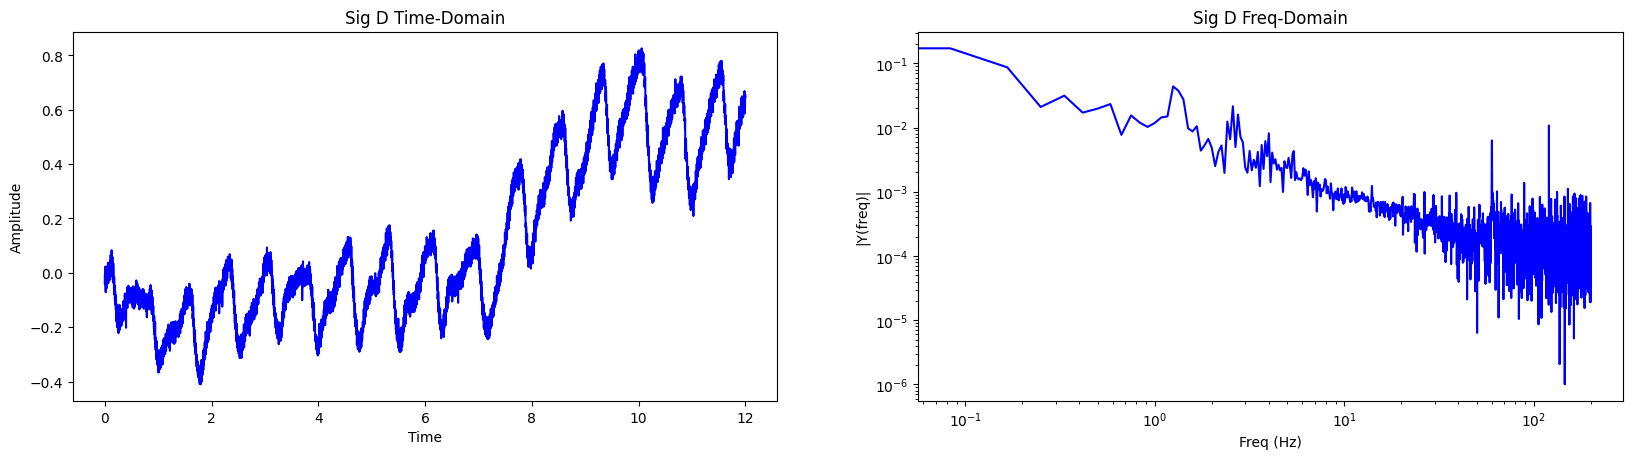

In [5]:
for sig, fs, name in zip(sigs, fss, names):
    t = sig['time']
    y = sig['sig']
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/fs

    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(int(n/2))]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(20)
    ax1.plot(t,y,'b')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Sig {} Time-Domain'.format(name))
    ax2.loglog(frq,abs(Y),'b') # plotting the fft
    ax2.set_xlabel('Freq (Hz)')
    ax2.set_ylabel('|Y(freq)|')
    ax2.set_title('Sig {} Freq-Domain'.format(name))
    plt.show()

In [6]:
def sig_fft(sig, fs):
    y = sig['sig']
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/fs

    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(int(n/2))]

    return (frq, Y)
    

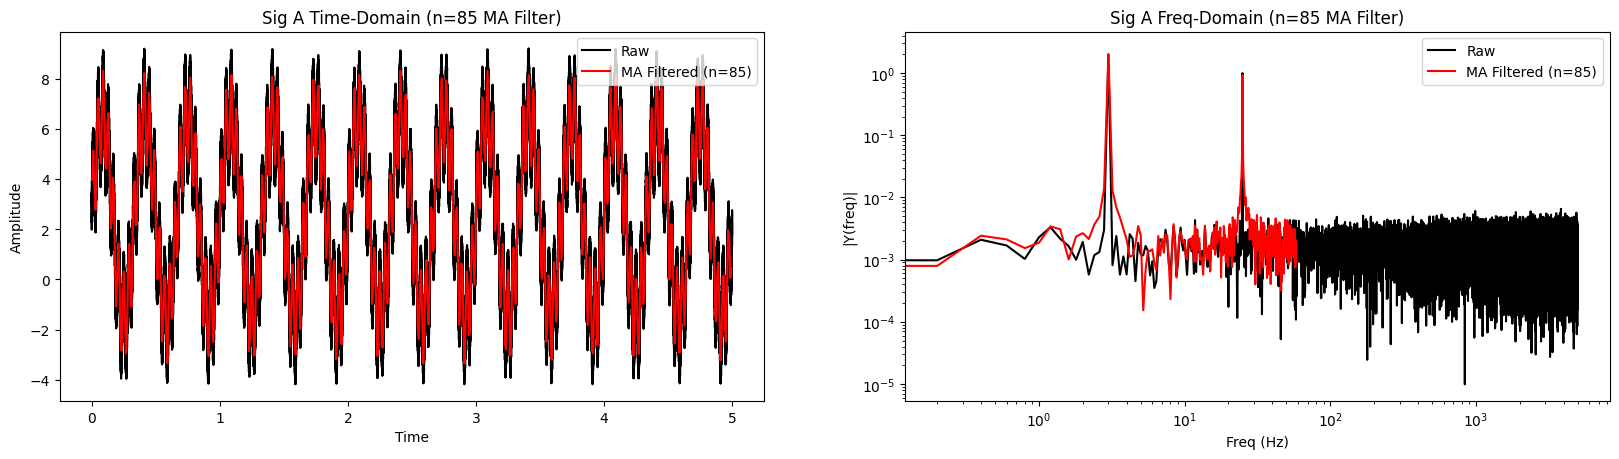

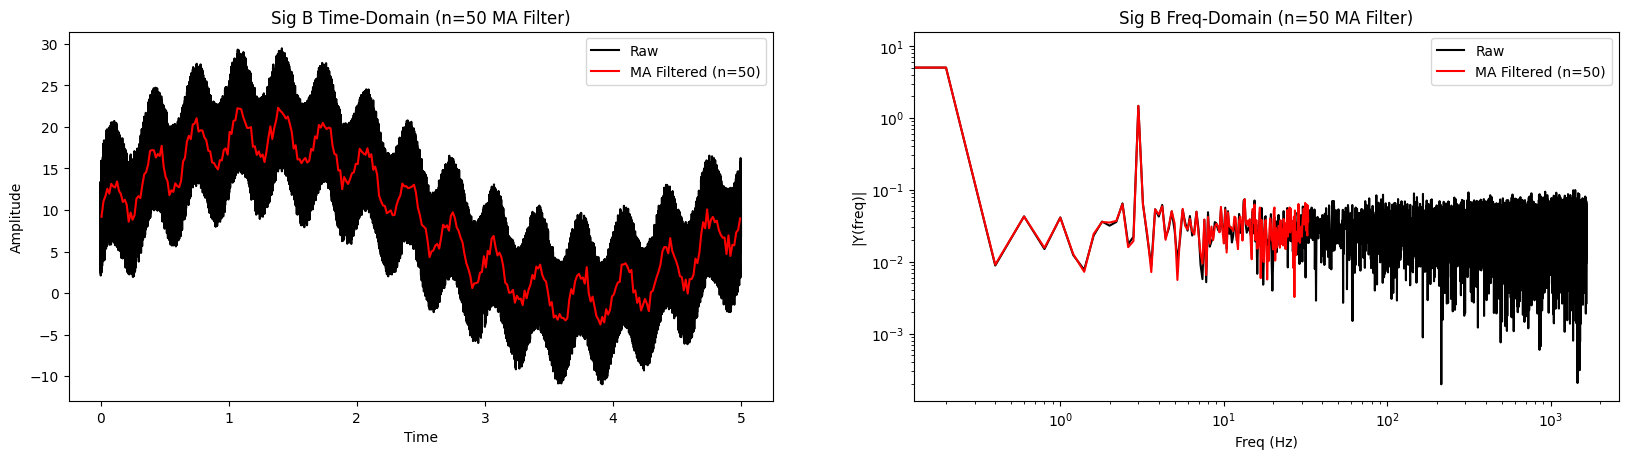

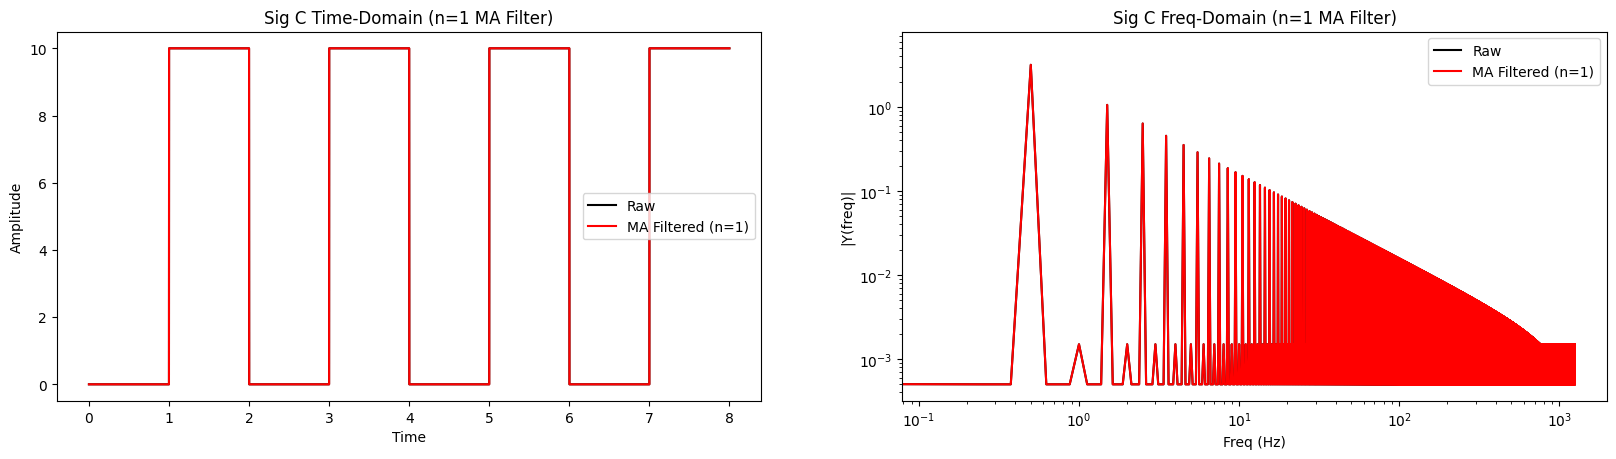

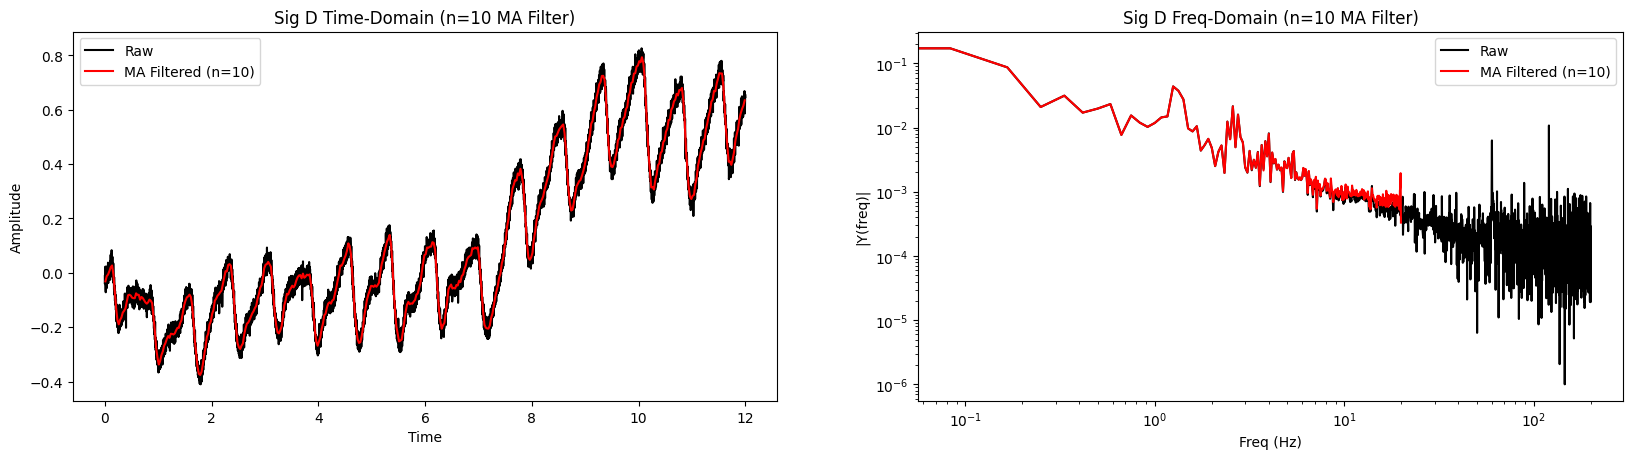

In [16]:
# moving avg filter
sigA_maf = pd.DataFrame(columns=['time', 'sig'])
sigB_maf = pd.DataFrame(columns=['time', 'sig'])
sigC_maf = pd.DataFrame(columns=['time', 'sig'])
sigD_maf = pd.DataFrame(columns=['time', 'sig'])

sigs_maf = [sigA_maf, sigB_maf, sigC_maf, sigD_maf]

# 0.0085 second long filter
maf_sizes = [int(fss[0] * 0.0085),50,1,10]
for sig, maf_size, sig_maf, name in zip(sigs, maf_sizes, sigs_maf, names):
    square_wave = np.ones(maf_size,) / maf_size

    sig_maf['time'] = np.convolve(sig['time'], square_wave, mode='valid')[::maf_size]
    sig_maf['sig'] = np.convolve(sig['sig'], square_wave, mode='valid')[::maf_size]

fss_maf = []
for fs, maf_size in zip(fss, maf_sizes):
    fss_maf.append(fs/maf_size)

for sig, sig_maf, maf_size,fs, fs_maf, name in zip(sigs, sigs_maf, maf_sizes,fss, fss_maf, names):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(20)
    ax1.plot(sig['time'],sig['sig'],'black')
    ax1.plot(sig_maf['time'],sig_maf['sig'],'red')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Sig {} Time-Domain (n={} MA Filter)'.format(name, maf_size))
    ax1.legend(['Raw', 'MA Filtered (n={})'.format(maf_size)])

    frq, Y = sig_fft(sig, fs)

    ax2.loglog(frq,abs(Y),'black') # plotting the fft

    frq_maf, Y_maf = sig_fft(sig_maf, fs_maf)

    ax2.loglog(frq_maf,abs(Y_maf),'red') # plotting the fft
    ax2.set_xlabel('Freq (Hz)')
    ax2.set_ylabel('|Y(freq)|')
    ax2.set_title('Sig {} Freq-Domain (n={} MA Filter)'.format(name, maf_size))
    ax2.legend(['Raw', 'MA Filtered (n={})'.format(maf_size)])
    fig.savefig('maf_{}.png'.format(name))

In [8]:
# 1st order linear IIR filter (slow / used for loops)
sigA_iir = pd.DataFrame(columns=['time', 'sig'])
sigB_iir = pd.DataFrame(columns=['time', 'sig'])
sigC_iir = pd.DataFrame(columns=['time', 'sig'])
sigD_iir = pd.DataFrame(columns=['time', 'sig'])

sigs_iir = [sigA_iir, sigB_iir, sigC_iir, sigD_iir]

iir_coeffs = [0.99, 0.95, 0, 0.9]
# for sig, alpha, sig_iir, name in zip([sigA], [iir_coeffs[0]], [sigA_iir], ["A"]): just to test one signal
for sig, alpha, sig_iir, name in zip(sigs, iir_coeffs, sigs_iir, names):
    AB = np.array([alpha, 1-alpha],ndmin=2)
    sig_iir['time'] = sig['time']
    n = sig['time'].size

    sig_iir.loc[0, 'sig'] = sig.loc[0, 'sig']
    
    for i in range(1, n):
        M = np.array([sig_iir.loc[i-1, 'sig'], sig.loc[i, 'sig']], ndmin=2).T
        sig_iir.loc[i, 'sig'] = np.dot(AB, M)[0]

fss_iir = fss

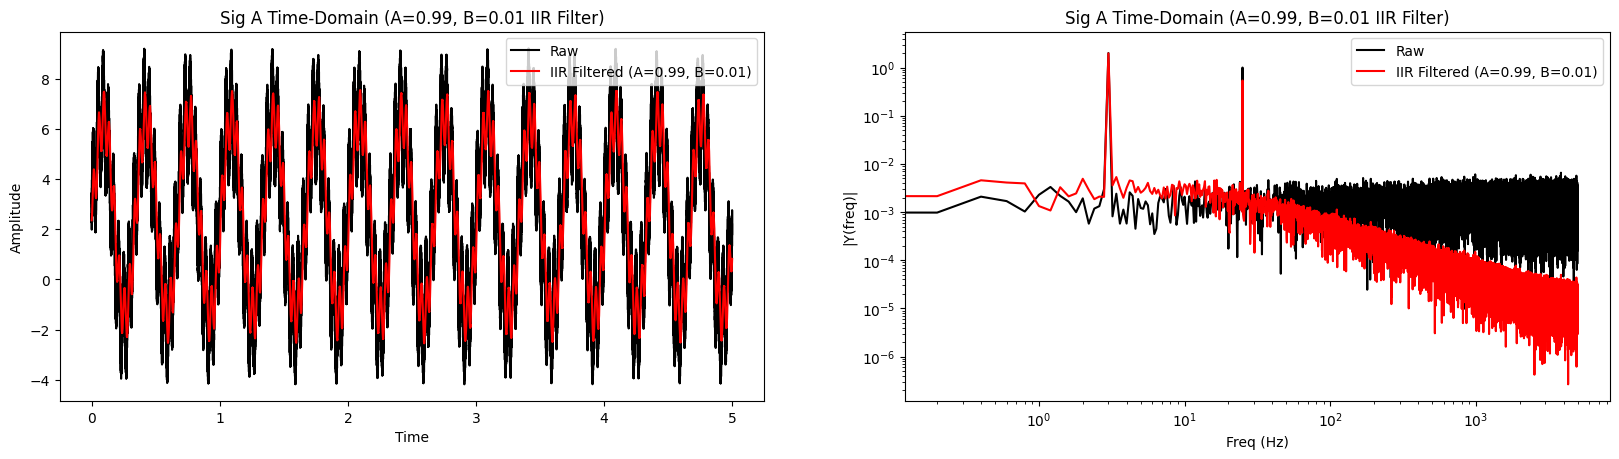

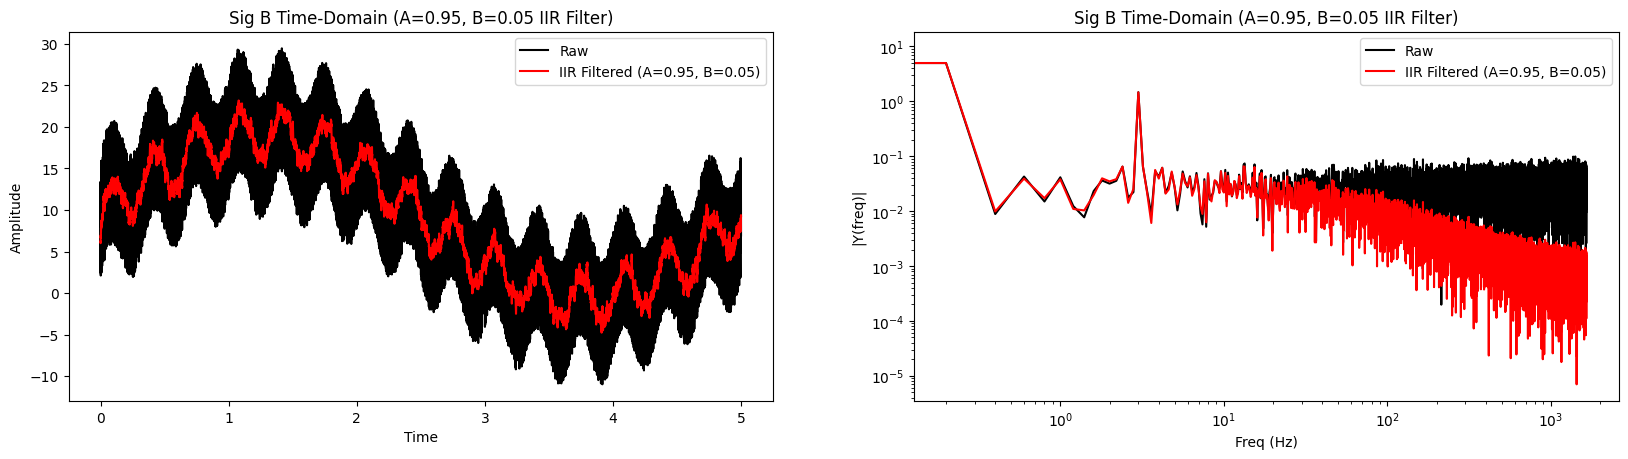

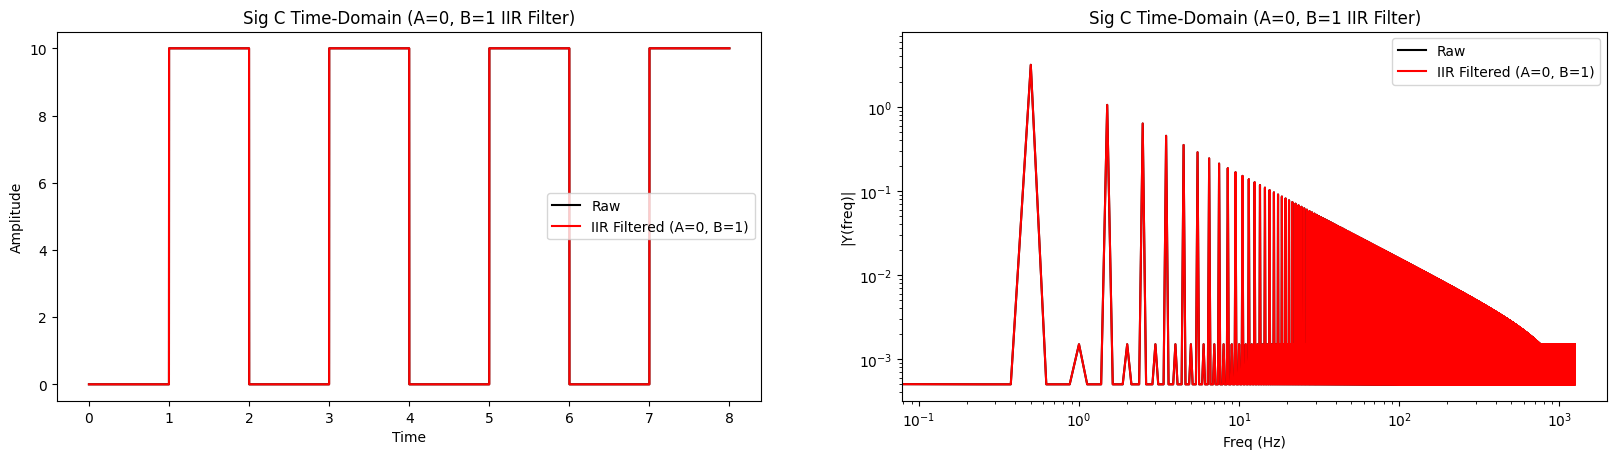

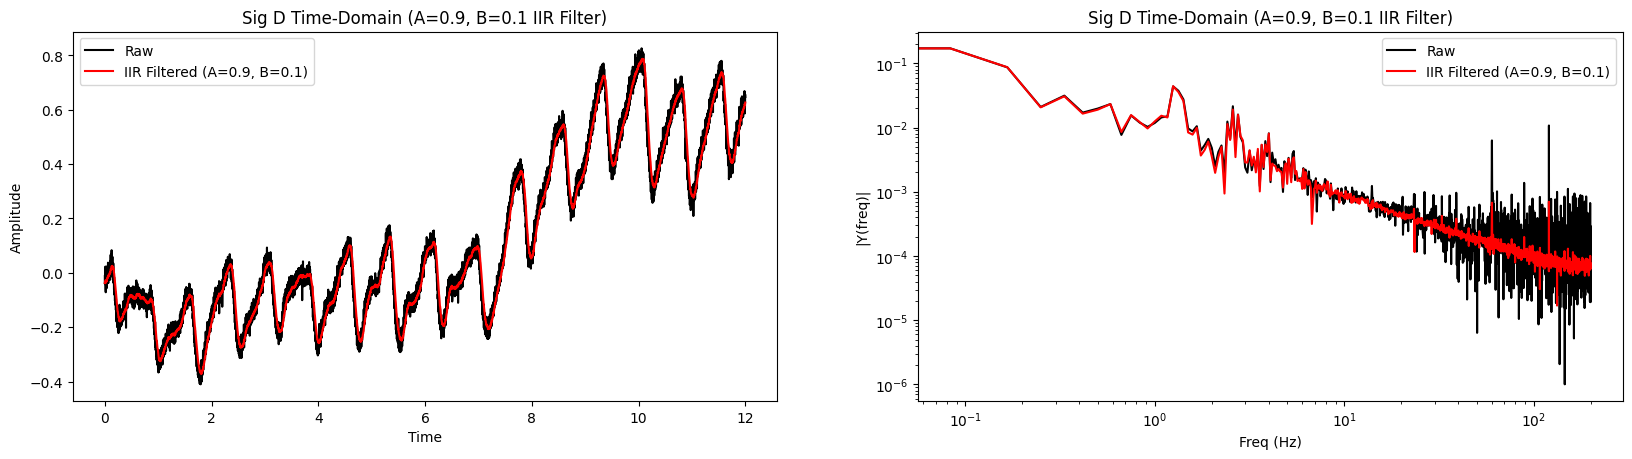

In [9]:
for sig, sig_iir, alpha , fs, name in zip(sigs, sigs_iir, iir_coeffs, fss, names):
    A = alpha
    B = round(1-alpha, 4)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(20)

    ax1.plot(sig['time'],sig['sig'],'black')
    ax1.plot(sig_iir['time'],sig_iir['sig'],'red')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Sig {} Time-Domain (A={}, B={} IIR Filter)'.format(name, A, B))
    ax1.legend(['Raw', 'IIR Filtered (A={}, B={})'.format(A, B)])

    frq, Y = sig_fft(sig, fs)

    ax2.loglog(frq,abs(Y),'black') # plotting the fft

    frq_iir, Y_iir = sig_fft(sig_iir, fs)

    ax2.loglog(frq_iir,abs(Y_iir),'red') # plotting the fft
    ax2.set_xlabel('Freq (Hz)')
    ax2.set_ylabel('|Y(freq)|')
    ax2.set_title('Sig {} Time-Domain (A={}, B={} IIR Filter)'.format(name, A, B))
    ax2.legend(['Raw', 'IIR Filtered (A={}, B={})'.format(A, B)])
    fig.savefig('iir_{}.png'.format(name))

In [10]:
# computes the coefficients of a low-pass windowed-sinc filter.
def lowpass_fir_coeff(cutoff, fs, N=59):
    fL = cutoff/fs
    # Compute sinc filter.
    h = np.sinc(2 * fL * (np.arange(N) - (N - 1) / 2))
    # Apply window.
    h = h * np.blackman(N)

    # Normalize to get unity gain.
    h /= np.sum(h)
    return h

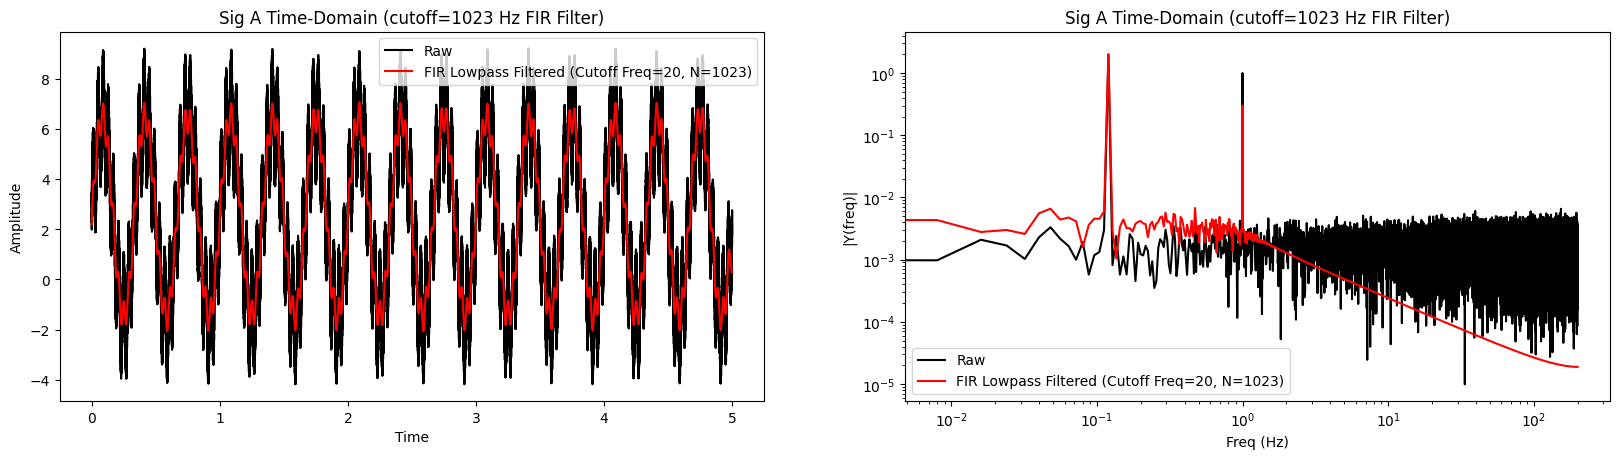

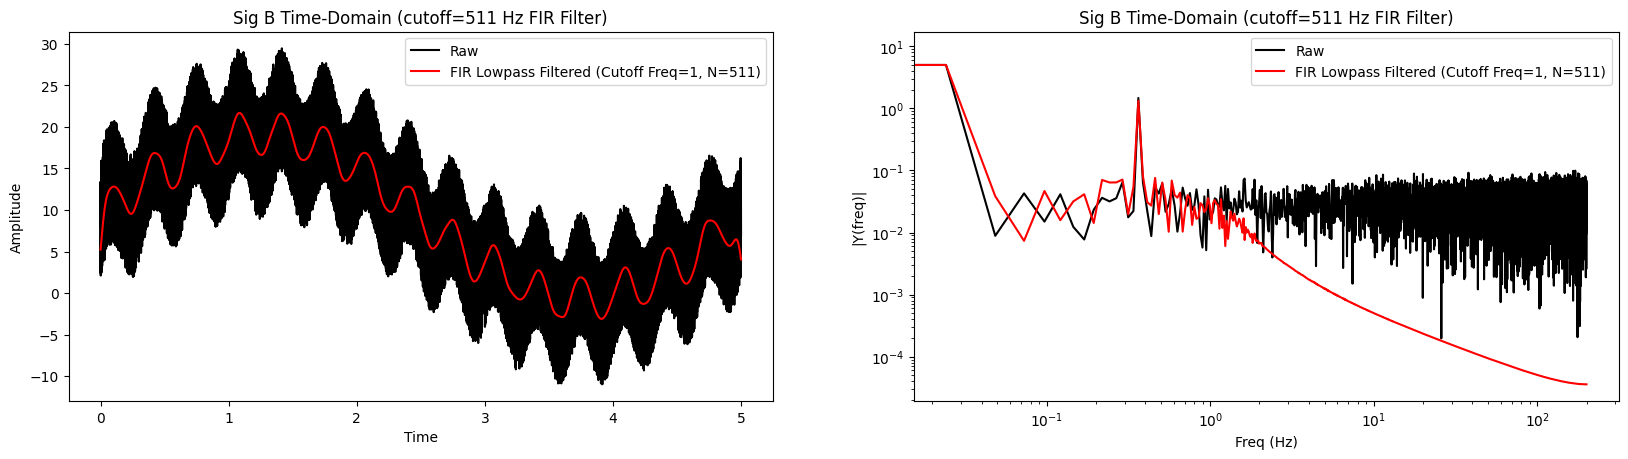

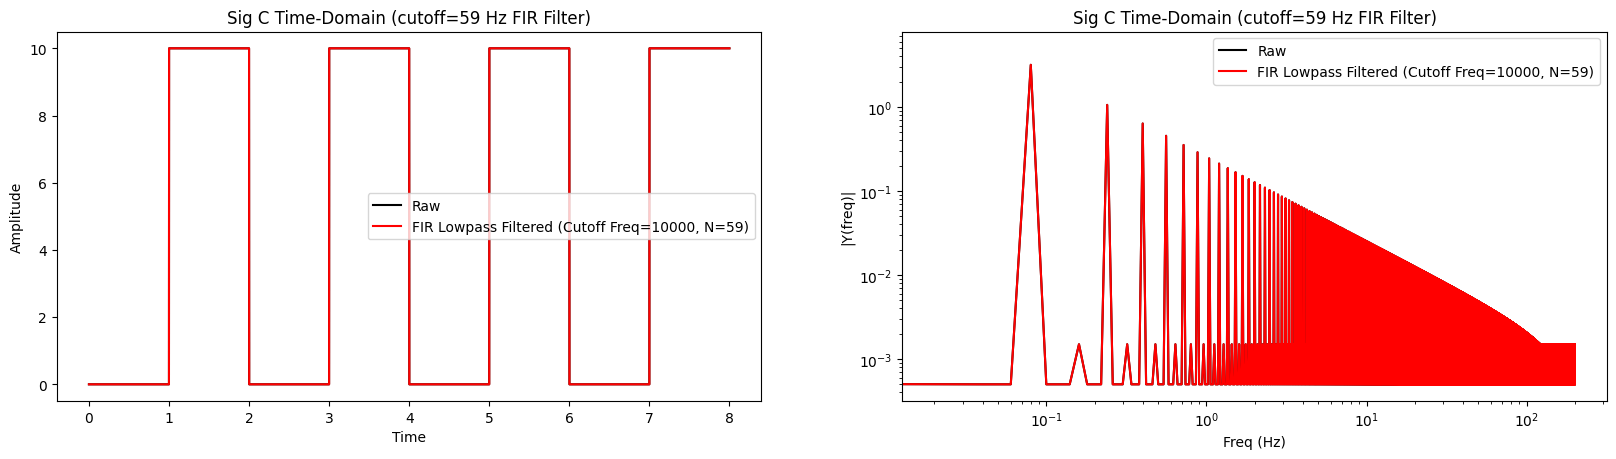

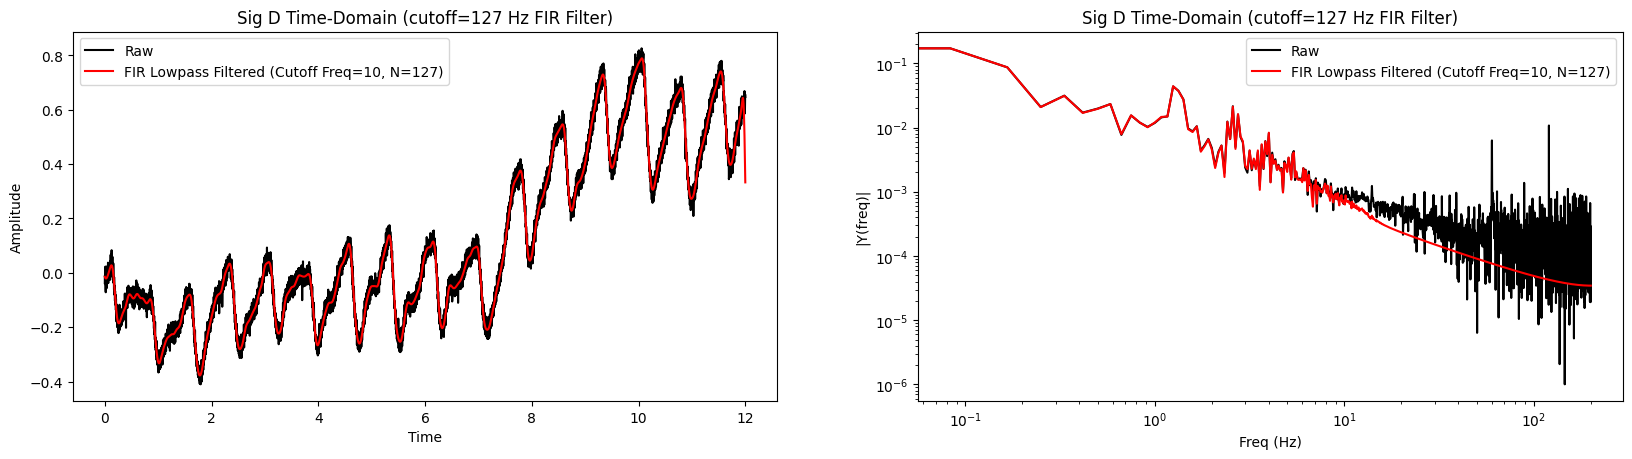

In [11]:
# fir filter
sigA_fir = pd.DataFrame(columns=['time', 'sig'])
sigB_fir = pd.DataFrame(columns=['time', 'sig'])
sigC_fir = pd.DataFrame(columns=['time', 'sig'])
sigD_fir = pd.DataFrame(columns=['time', 'sig'])

sigs_fir = [sigA_fir, sigB_fir, sigC_fir, sigD_fir]

cutoffs = [2*10**1, 10**0, 10**4, 10**1]


fir_coeffs = []
fir_sizes = [2**10-1, 2**9-1, 59, 2**7-1]

for cutoff, fs, fir_size in zip(cutoffs, fss, fir_sizes):
    coeff = lowpass_fir_coeff(cutoff, fs, N=fir_size)
    fir_coeffs.append(coeff)

for sig, fir_coeff, sig_fir, fir_size, name in zip(sigs, fir_coeffs, sigs_fir, fir_sizes, names):
    sig_fir['time'] = sig['time']
    sig_fir['sig'] = np.convolve(sig['sig'], fir_coeff, mode='same')

for sig, sig_fir, cutoff, fir_size, name in zip(sigs, sigs_fir, cutoffs, fir_sizes, names):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(20)

    ax1.plot(sig['time'],sig['sig'],'black')
    ax1.plot(sig_fir['time'],sig_fir['sig'],'red')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Sig {} Time-Domain (cutoff={} Hz FIR Filter)'.format(name, fir_size))
    ax1.legend(['Raw', 'FIR Lowpass Filtered (Cutoff Freq={}, N={})'.format(cutoff, fir_size)])

    frq, Y = sig_fft(sig, fs)

    ax2.loglog(frq,abs(Y),'black') # plotting the fft

    frq_fir, Y_fir = sig_fft(sig_fir, fs)

    ax2.loglog(frq_fir,abs(Y_fir),'red') # plotting the fft
    ax2.set_xlabel('Freq (Hz)')
    ax2.set_ylabel('|Y(freq)|')
    ax2.set_title('Sig {} Time-Domain (cutoff={} Hz FIR Filter)'.format(name, fir_size))
    ax2.legend(['Raw', 'FIR Lowpass Filtered (Cutoff Freq={}, N={})'.format(cutoff, fir_size)])
    fig.savefig('fir_{}.png'.format(name))